In [1]:
# Import essential libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import pickle
from collections import Counter, defaultdict

import scanpy as sc  # For single-cell RNA-seq data
import anndata  # Annotated data matrix
import bbknn  # Batch-balanced KNN

# Seaborn and Matplotlib for visualization
import seaborn as sns
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/

### 2.1 Load and normalize data

In [2]:
with open('gene_dict.pkl', 'rb') as f:
    gene_dict = pickle.load(f)

In [3]:
with open('process_dict.pkl', 'rb') as f:
    process_dict = pickle.load(f)

In [4]:
# Load preprocessed datasets for three experiments
exp100=sc.read('exp100.h5',gex_only=False)
exp105=sc.read('exp105.h5',gex_only=False)
exp106=sc.read('exp106.h5',gex_only=False)

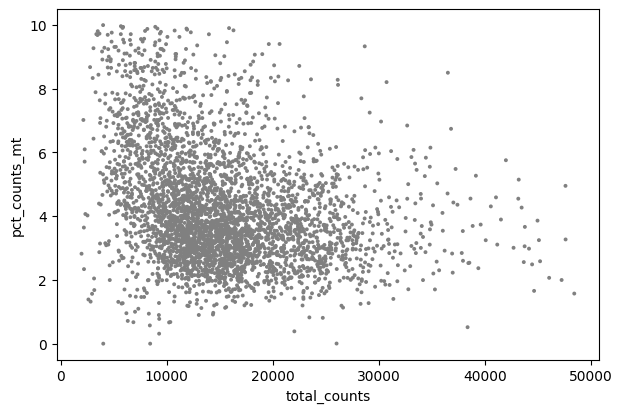

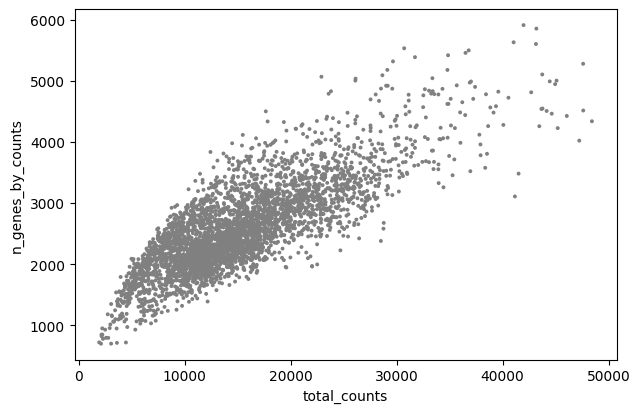

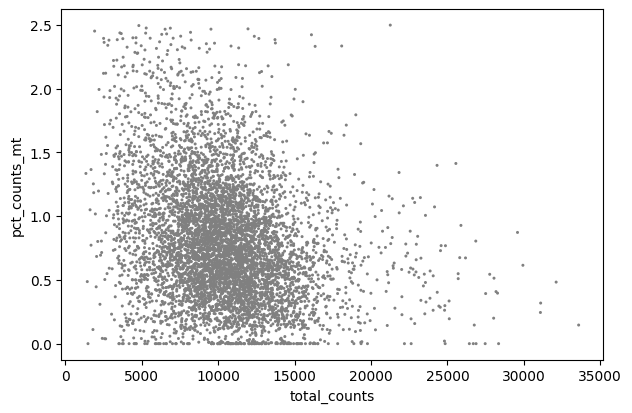

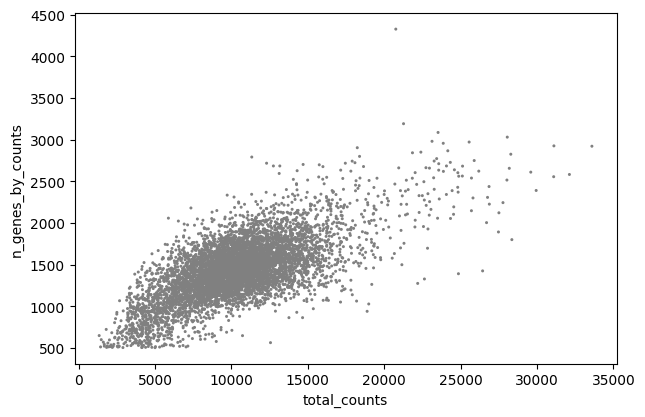

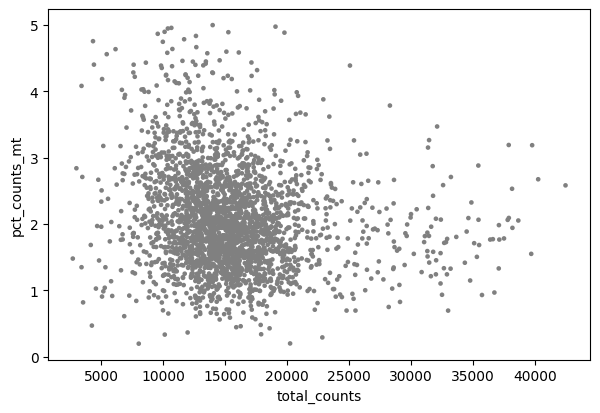

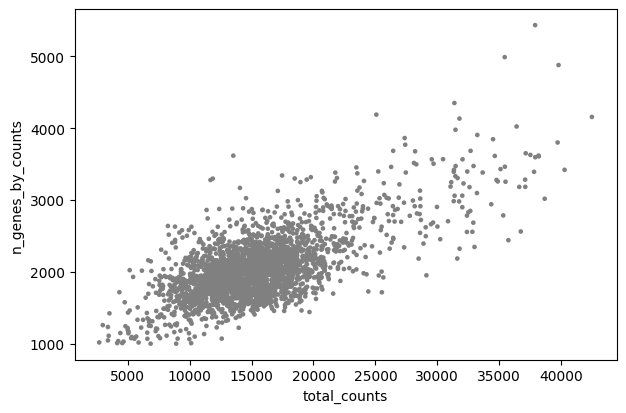

In [5]:
# Visualize QC metrics through scatter plots for each experiment
sc.pl.scatter(exp100, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(exp100, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(exp105, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(exp105, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(exp106, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(exp106, x='total_counts', y='n_genes_by_counts')

In [6]:
# Concatenate the three datasets into one combined dataset
data = exp100.concatenate(exp105, exp106, batch_key='sample')

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [7]:
# Save the concatenated dataset
data.write('3data_raw.h5')

In [8]:
data1=data.copy() 

In [9]:
# Subset data based on the sample ID
d0=data1[data1.obs['sample']=='0']
d1=data1[data1.obs['sample']=='1']
d2=data1[data1.obs['sample']=='2']

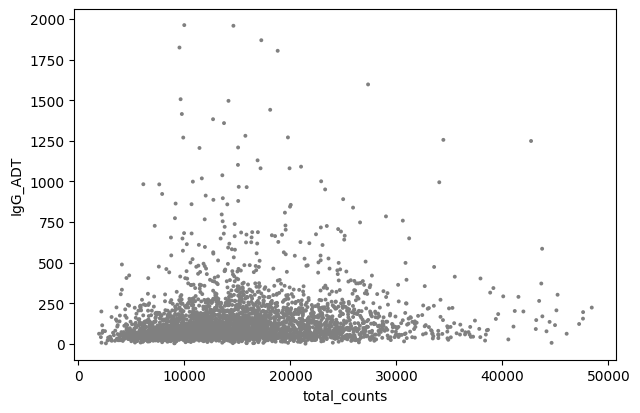

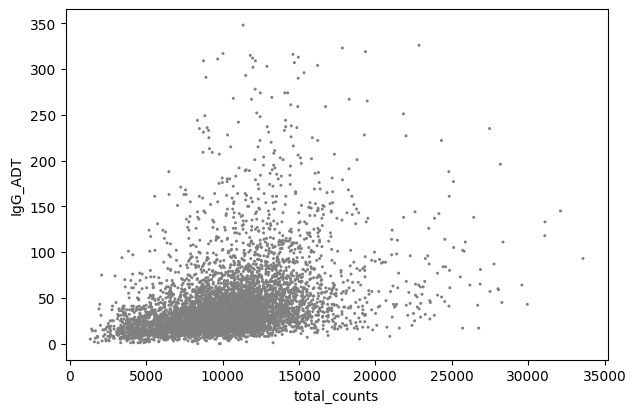

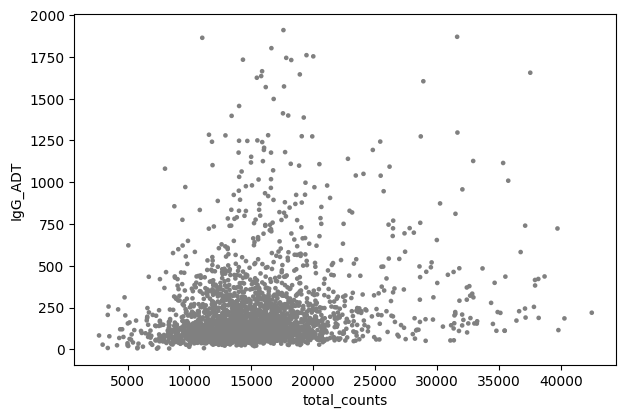

In [10]:
# Generate scatter plots for the three sample to show the relationship between total RNA counts and IgG_ADT
sc.pl.scatter(d0, x='total_counts', y='IgG_ADT')
sc.pl.scatter(d1, x='total_counts', y='IgG_ADT')
sc.pl.scatter(d2, x='total_counts', y='IgG_ADT')

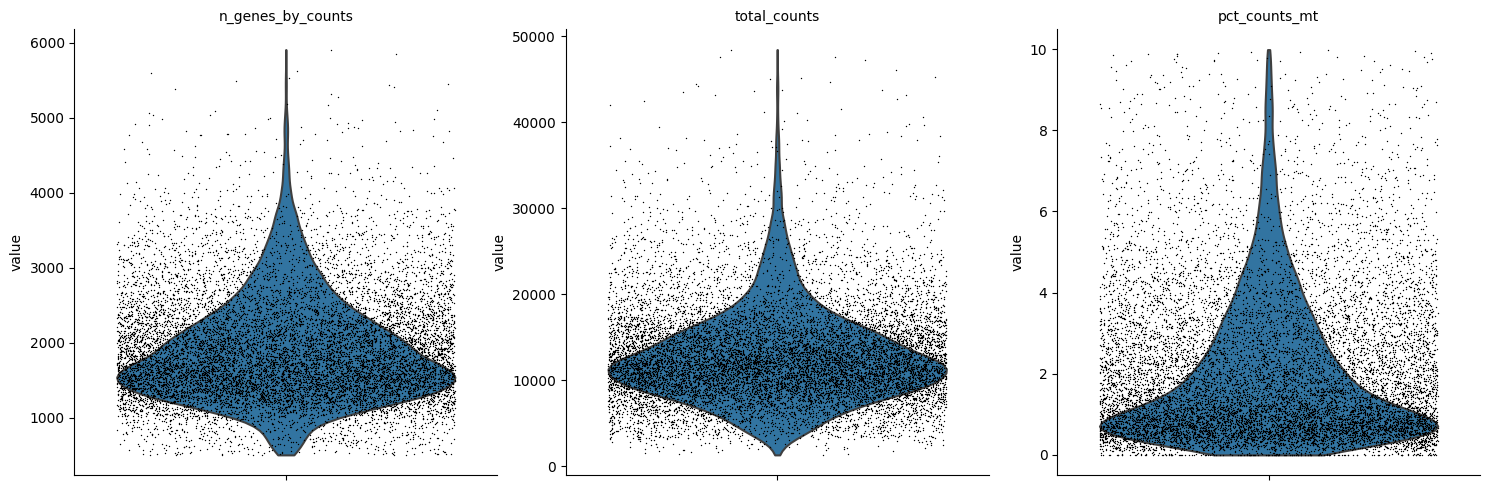

In [11]:
# Create violin plots for key quality control metrics ('n_genes_by_counts', 'total_counts', 'pct_counts_mt') across all samples
sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [12]:
# Extract only the gene expression data from the full dataset and store it in a new variable 'rna'
rna=data[:, data.var["feature_types"] == "Gene Expression"].copy()

In [13]:
# Extract only the antibody capture data from the full dataset and store it in a new variable 'adt'
adt=data[:, data.var["feature_types"] == "Antibody Capture"].copy()

In [14]:
# Normalize the gene expression data so that the total counts for each cell sum to a constant value
sc.pp.normalize_total(rna)
# Apply logarithmic scaling to the normalized data
sc.pp.log1p(rna)

In [15]:
# Perform Principal Component Analysis (PCA) on the gene expression data for dimensionality reduction
sc.pp.pca(rna)
# Perform Batch Balanced K-Nearest Neighbors (BBKNN) to correct for batch effects in the data
sc.external.pp.bbknn(rna, batch_key='sample')

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


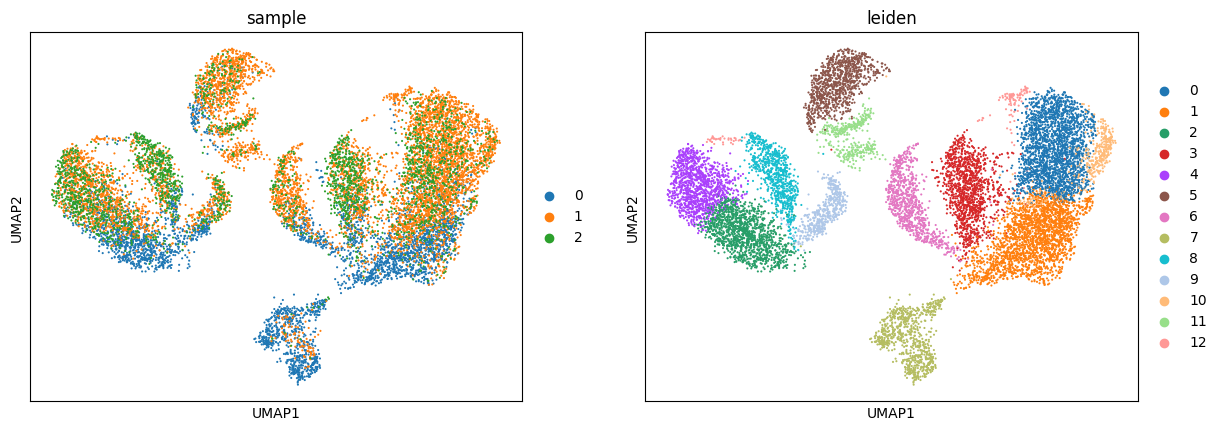

In [16]:
# Apply UMAP (Uniform Manifold Approximation and Projection) for data visualization
sc.tl.umap(rna)
# Cluster the cells using the Leiden algorithm
sc.tl.leiden(rna,resolution = 0.7)
# Visualize the UMAP plot, colored by sample origin and Leiden cluster assignments
sc.pl.umap(rna, color=['sample','leiden'])

/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:368: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/pablodigiusto/miniforge3/envs/secrecon/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


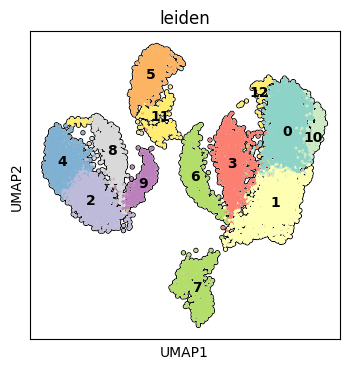

In [17]:
# Generate a UMAP plot for the 'rna' object, colored by Leiden cluster
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(rna, color=["leiden"], size=20,alpha=1,legend_loc="on data", 
               add_outline=True,palette='Set3', show=False)
plt.savefig('leiden.pdf')

### 2.2 Identify secretory pathway genes in Leiden clusters

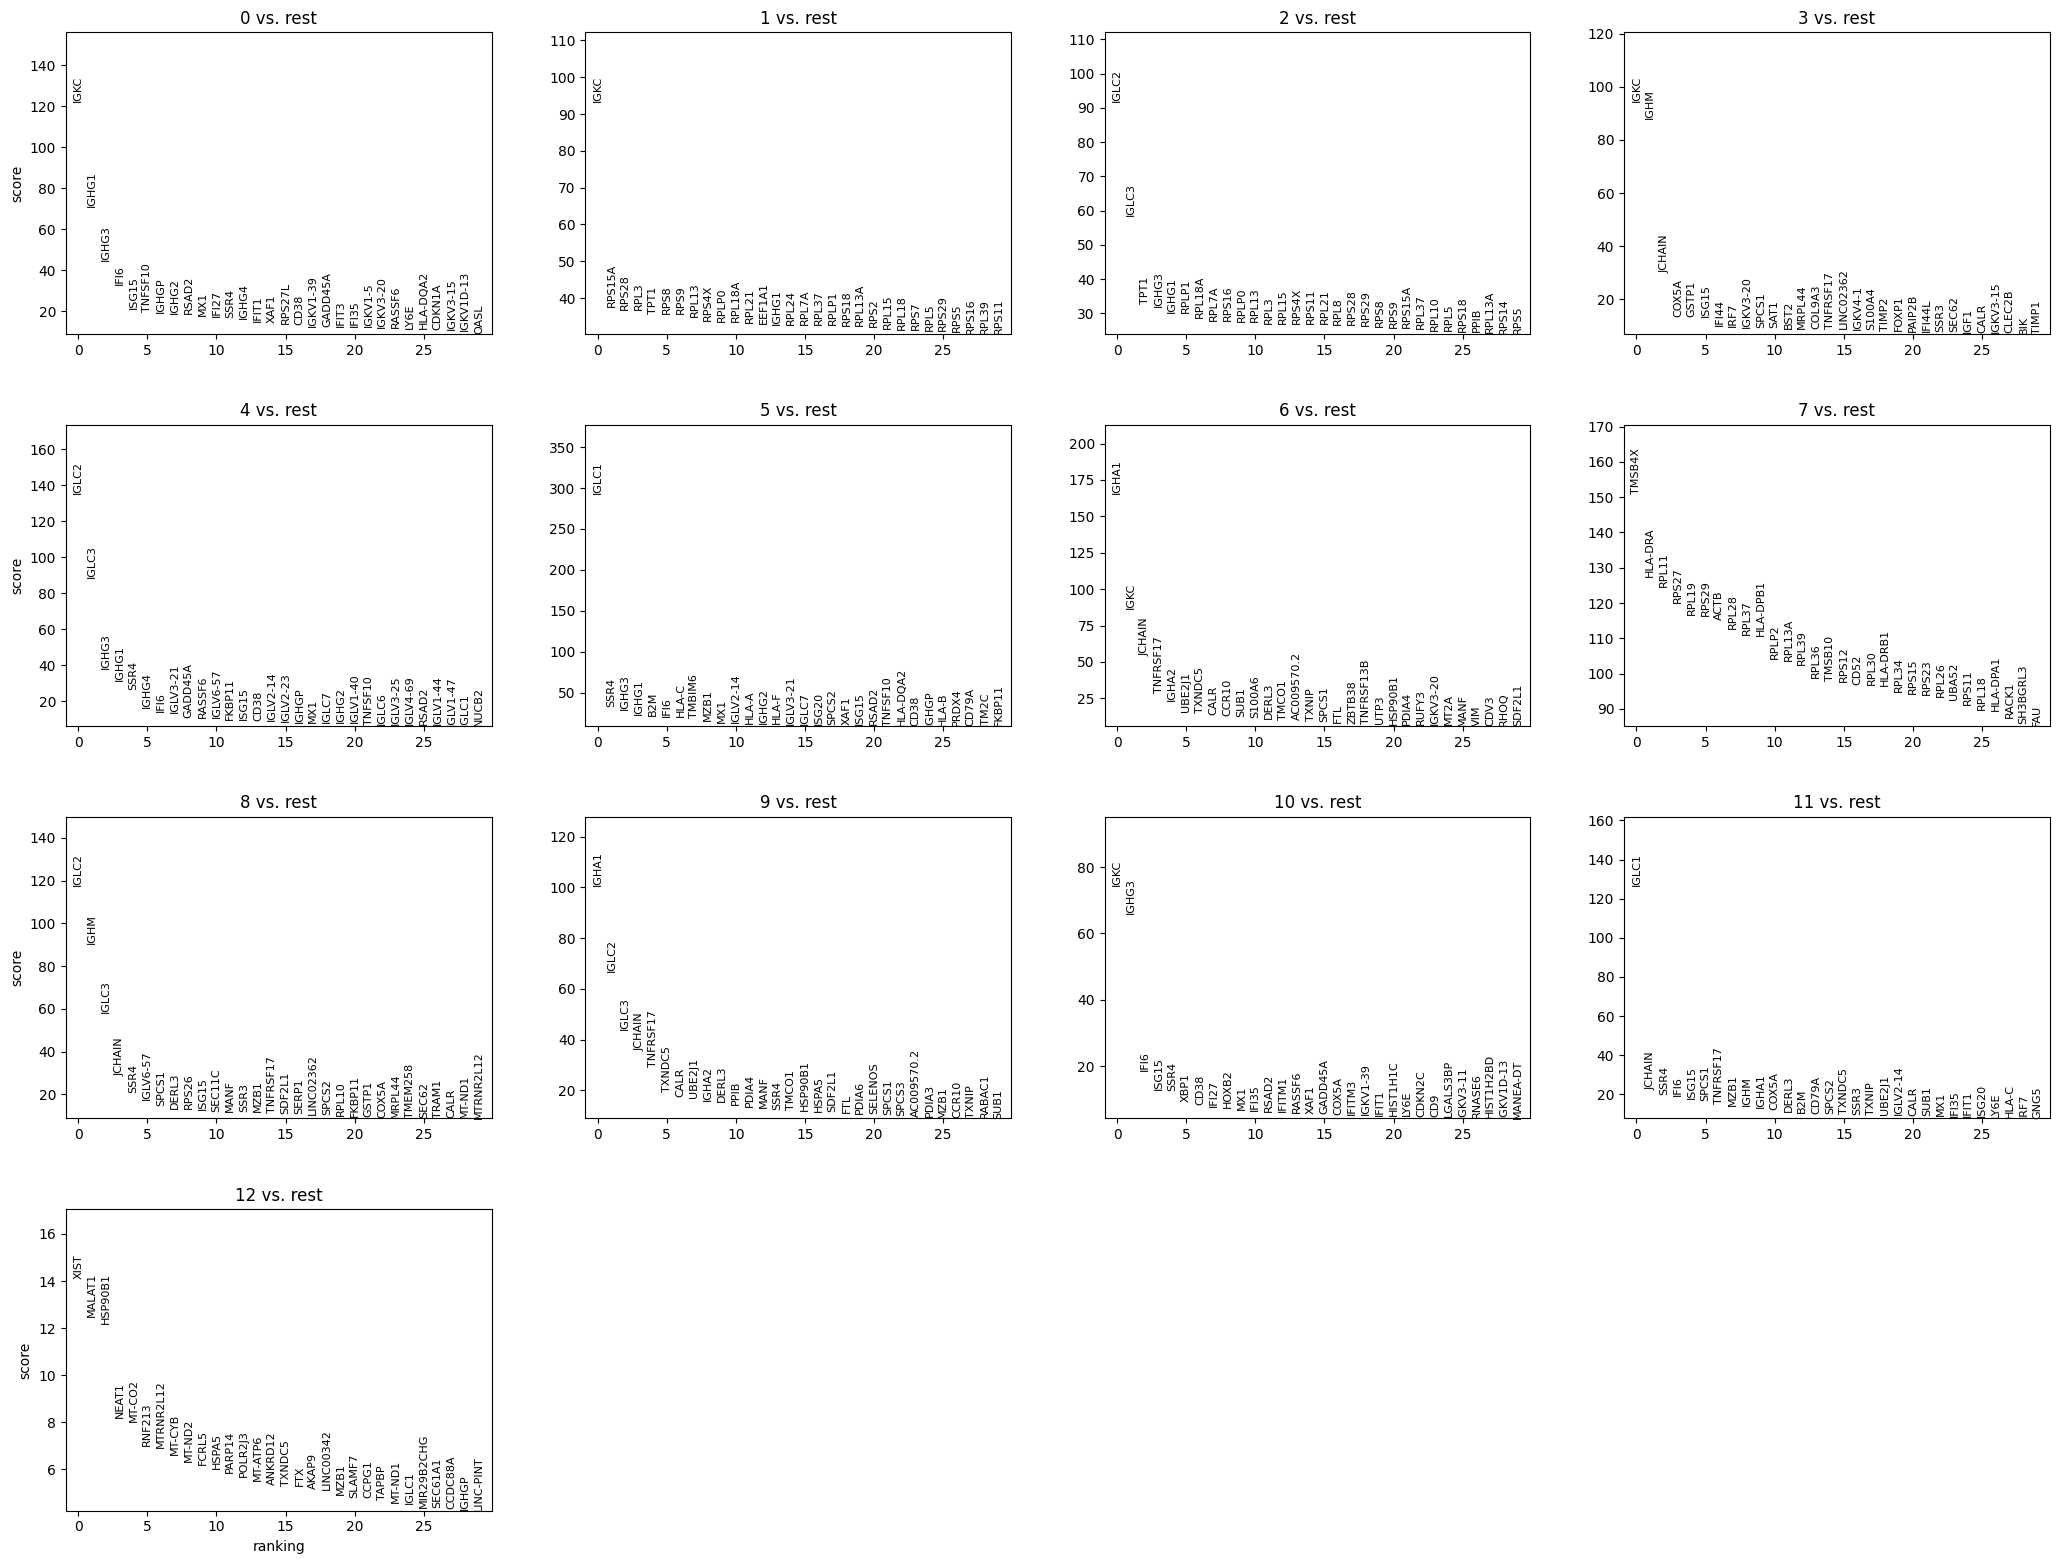

In [18]:
# Rank genes that are differentially expressed between Leiden clusters using the t-test method
rna_t=sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')
# Plot the top 30 differentially expressed genes for each cluster
sc.pl.rank_genes_groups(rna, n_genes=30, sharey=False)

In [19]:
# Access the structured array of results
results = rna.uns['rank_genes_groups']
# Access the names of the genes, which are stored under 'names'
gene_names = results['names']
# Convert to a DataFrame for easier manipulation
df = pd.DataFrame(gene_names)

# Create a dictionary to store the top genes for each cluster
top_genes_dict = {}
for i in range(13):
    top_genes_dict[i] = set(df[str(i)].head(30))

In [20]:
# Create a dictionary to store the intersections along with attributes
intersect_dict = {}

# Loop through each cluster and filter the secretory pathway genes from the "gene_dict"
for i in range(13):
    intersecting_genes = set(gene_dict.keys()).intersection(top_genes_dict[i])
    
    # Create a nested dictionary for each cluster
    nested_dict = {}
    
    # Populate the nested dictionary with attributes from gene_dict ('processes', 'subcellular_localization', 'complex')
    for gene in intersecting_genes:
        nested_dict[gene] = gene_dict.get(gene, {})
    
    # Update intersect_dict with the nested dictionary
    intersect_dict[i] = nested_dict

intersect_dict

{0: {'SSR4': {'processes': ['Co-translational translocation'],
   'subcellular_localization': ['Endoplasmic Reticulum'],
   'complex': ['Signal sequence receptors (SSR) complex']}},
 1: {},
 2: {'PPIB': {'processes': ['Protein folding'],
   'subcellular_localization': [],
   'complex': 'Not part of any complex'}},
 3: {'SPCS1': {'processes': ['Translocation',
    'Post-translational modifications',
    'Protein folding',
    'ERAD'],
   'subcellular_localization': ['Endoplasmic Reticulum'],
   'complex': ['Microsomal signal peptidase (SPC/SPase) COMPLEX']},
  'SSR3': {'processes': ['Co-translational translocation'],
   'subcellular_localization': ['Endoplasmic Reticulum'],
   'complex': ['Signal sequence receptors (SSR) complex']},
  'CALR': {'processes': ['Protein folding',
    'ER Ca Homeostasis ',
    'Retrotranslocation'],
   'subcellular_localization': ['Endoplasmic Reticulum', 'Cytoplasm'],
   'complex': 'Not part of any complex'},
  'SEC62': {'processes': ['Post-translational tr

In [21]:
# Create new dictionary with the parent categories as subkeys and the amount of genes as items
categorized_intersect_dict = {}

# Loop through each cluster in intersect_dict
for cluster, genes in intersect_dict.items():
    categorized_intersect_dict[cluster] = {}
    
    # Initialize counters for each category
    category_counters = {
        'Translocation': 0,
        'Protein conformation': 0,
        'Post-translational modifications': 0,
        'Proteostasis': 0,
        'Vesicle trafficking': 0
    }
    
    # Loop through each gene in the cluster
    for gene, attributes in genes.items():
        process_counter = Counter()
        
        # Loop through each process for the gene
        for process in attributes['processes']:
            
            # Loop through each category in process_dict
            for category, sub_processes in process_dict.items():
                
                # Check if the process is in this category
                for sub_process_dict in sub_processes:
                    if process == sub_process_dict.get('Subsystem') or \
                       process == sub_process_dict.get('Process') or \
                       process == sub_process_dict.get('Subprocess'):
                        process_counter[category] += 1
        
        # Determine the category where the majority of processes for this gene are allocated
        if process_counter:  # Check if process_counter is not empty
            most_common_category, _ = process_counter.most_common(1)[0]
            
            # Add the gene to this category in the categorized dictionary
            if most_common_category not in categorized_intersect_dict[cluster]:
                categorized_intersect_dict[cluster][most_common_category] = []
            categorized_intersect_dict[cluster][most_common_category].append(gene)
        else:
            # Handle genes with no processes
            if 'No Category' not in categorized_intersect_dict[cluster]:
                categorized_intersect_dict[cluster]['No Category'] = []
            categorized_intersect_dict[cluster]['No Category'].append(gene)

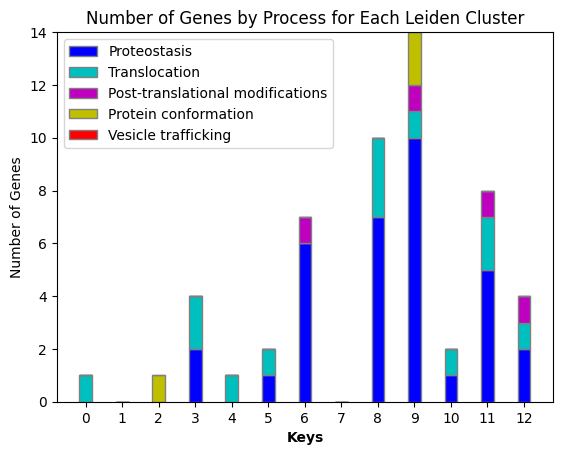

In [26]:
## --- Plot ----#

labels = list(categorized_intersect_dict.keys())
proteostasis = []
translocation = []
post_trans_mod = []
protein_conf = []
vesicle_traffic = []

# Populate the lists with the number of genes for each subkey
for key in labels:
    proteostasis.append(len(categorized_intersect_dict[key].get('Proteostasis', [])))
    translocation.append(len(categorized_intersect_dict[key].get('Translocation', [])))
    post_trans_mod.append(len(categorized_intersect_dict[key].get('Post-translational modifications', [])))
    protein_conf.append(len(categorized_intersect_dict[key].get('Protein conformation', [])))
    vesicle_traffic.append(len(categorized_intersect_dict[key].get('Vesicle trafficking', [])))

# Define the bar width
barWidth = 0.35

# Set position of bar on X axis
r1 = np.arange(len(labels))

# Make the plot
plt.bar(r1, proteostasis, color='b', edgecolor='grey', width=barWidth, label='Proteostasis')
plt.bar(r1, translocation, color='c', edgecolor='grey', width=barWidth, bottom=proteostasis, label='Translocation')
plt.bar(r1, post_trans_mod, color='m', edgecolor='grey', width=barWidth, bottom=[i+j for i,j in zip(proteostasis, translocation)], label='Post-translational modifications')
plt.bar(r1, protein_conf, color='y', edgecolor='grey', width=barWidth, bottom=[i+j+k for i,j,k in zip(proteostasis, translocation, post_trans_mod)], label='Protein conformation')
plt.bar(r1, vesicle_traffic, color='r', edgecolor='grey', width=barWidth, bottom=[i+j+k+l for i,j,k,l in zip(proteostasis, translocation, post_trans_mod, protein_conf)], label='Vesicle trafficking')

# Add labels
plt.xlabel('Keys', fontweight='bold')
plt.ylabel('Number of Genes')
plt.xticks([r for r in range(len(labels))], labels)
plt.title('Number of Genes by Process for Each Leiden Cluster')
plt.legend()

# Show plot
plt.savefig('Plots/number_of_genes_by_process_each_leiden.jpg', dpi=300)
plt.show()

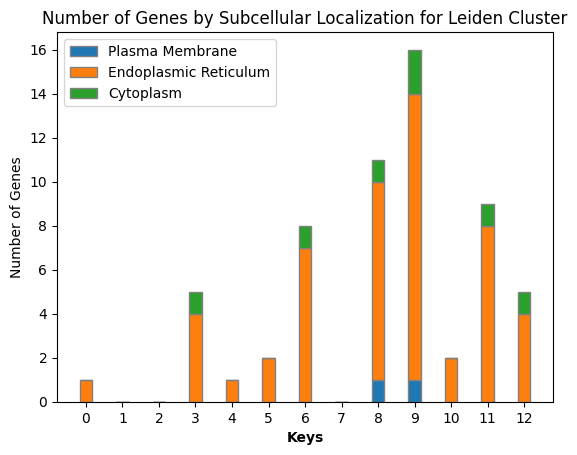

In [25]:
labels = list(intersect_dict.keys())
localization_counts = defaultdict(list)

# Populate the dictionary with the number of genes for each subcellular localization
for key in labels:
    local_count = defaultdict(int)
    for gene, attributes in intersect_dict[key].items():
        for local in attributes.get('subcellular_localization', []):
            local_count[local] += 1
    localization_counts[key] = local_count

# Define the bar width
barWidth = 0.35

# Set position of bar on X axis
r1 = np.arange(len(labels))

# Initialize bottom for stacked bar
bottoms = np.zeros(len(labels))

# Make the plot
for local in set(local for d in localization_counts.values() for local in d.keys()):
    heights = [localization_counts[key].get(local, 0) for key in labels]
    plt.bar(r1, heights, edgecolor='grey', width=barWidth, bottom=bottoms, label=local)
    bottoms += np.array(heights)

# Add labels
plt.xlabel('Keys', fontweight='bold')
plt.ylabel('Number of Genes')
plt.xticks([r for r in range(len(labels))], labels)
plt.title('Number of Genes by Subcellular Localization for Leiden Cluster')
plt.legend()

# Show plot
plt.savefig('Plots/number_of_genes_subcellular_localization_each_leiden.jpg', dpi=300)
plt.show()

In [27]:
# Create an empty dictionary to store DataFrames for each cluster
cluster_dfs = {}

# Loop through each unique cluster and extract the expression data
unique_clusters = rna.obs['leiden'].unique().tolist()

for cluster in unique_clusters:
    subset_data = rna[rna.obs['leiden'] == cluster, :]
    
    # Convert the expression data to a DataFrame
    expression_df = pd.DataFrame(subset_data.X.toarray(), columns=subset_data.var_names, index=subset_data.obs_names)
    
    # Add a column to label the cluster
    expression_df['cluster'] = cluster
    
    # Store the DataFrame in the dictionary
    cluster_dfs[cluster] = expression_df

# Concatenate all the DataFrames to create a single DataFrame
final_df = pd.concat(cluster_dfs.values())

# Now, final_df contains the expression data for all genes in each cluster, along with a 'cluster' column to indicate the cluster label

In [ ]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the UMAP coordinates without color
sc.pl.umap(rna, color=None, ax=ax, show=False, size=15, frameon=False)

# List of genes to color
genes_to_color = ['DERL3', 'UBE2J1', 'HSPA5', 'CALR', 'PDIA4', 'HSP90B1', 'SELENOS', 'PDIA3', 'SPCS3', 'SPCS1']

# Get UMAP coordinates
umap_coords = rna.obsm['X_umap']

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 8))

# Loop through each gene and add a color layer
for gene in genes_to_color:
    expression_values = rna[:, gene].X.toarray().flatten() if hasattr(rna[:, gene].X, 'toarray') else rna[:, gene].X
    #normalized_values = (expression_values - np.min(expression_values)) / (np.max(expression_values) - np.min(expression_values))
    ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=expression_values, cmap='Purples', alpha=0.5, label=gene)

# Add legend and labels
ax.legend()
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# Show the plot
plt.show()

In [ ]:
# Plot a UMAP visualization colored by expression levels of the gene 'MIF'
with rc_context({'figure.figsize': (8.4, 8)}):

#     ax = sc.pl.umap(rna, size=50, show=False)
    ax=sc.pl.umap(rna,color=['DERL3','UBE2J1','HSPA5','CALR','PDIA4','HSP90B1','SELENOS','PDIA3','SPCS3','SPCS1'], legend_loc='none',size=15,show=False, alpha=1,
                    add_outline=True,frameon=False, cmap='Purples',colorbar_loc=None,vmin=1.5,
                   )
    #ax.set_title('')   
plt.show()

In [ ]:
# Group data by 'sample' and 'leiden' cluster, then normalize within each group to create a stacked bar plot
d=rna.obs
dd=d.groupby('sample')['leiden'].value_counts(normalize=True).unstack('sample')
# al=d['leiden'].value_counts(normalize=True)
# dd['all']= al

labels = dd.columns
c0= dd.iloc[0]
c1 =  dd.iloc[1]
c2 = dd.iloc[2]
c3 = dd.iloc[3]
c4 = dd.iloc[4]
c5 = dd.iloc[5]
c6 = dd.iloc[6]
c7 = dd.iloc[7]
c8 = dd.iloc[8]
c9 = dd.iloc[9]
c10 = dd.iloc[10]

fig = plt.figure(figsize=(1,4))
ax = fig.add_subplot(111)
width = 0.55       # the width of the bars: can also be len(x) sequence

cmap=mpl.colormaps.get_cmap("Set3").colors
ax.bar(labels, c0, width,color=cmap[0],alpha=1)
ax.bar(labels, c1, width, bottom=c0,color=cmap[1],alpha=1,)
ax.bar(labels, c2, width, bottom=c0+c1,color=cmap[2],alpha=1,)
ax.bar(labels, c3, width, bottom=c0+c1+c2,color=cmap[3],alpha=1,)
ax.bar(labels, c4, width, bottom=c0+c1+c2+c3,color=cmap[4],alpha=1,)
ax.bar(labels, c5, width, bottom=c0+c1+c2+c3+c4,color=cmap[6],alpha=1,)
ax.bar(labels, c6, width, bottom=c0+c1+c2+c3+c4+c5,color=cmap[7],alpha=1,)
ax.bar(labels, c7, width, bottom=c0+c1+c2+c3+c4+c5+c6,color=cmap[8],alpha=1,)
ax.bar(labels, c8, width, bottom=c0+c1+c2+c3+c4+c5+c6+c7,color=cmap[9],alpha=1,)
ax.bar(labels, c9, width, bottom=c0+c1+c2+c3+c4+c5+c6+c7+c8,color=cmap[10],alpha=1,)
ax.bar(labels, c10, width, bottom=c0+c1+c2+c3+c4+c5+c6+c7+c8+c9,color=cmap[11],alpha=1,)



# plt.ylim(0,1.1)

# plt.savefig('gbar.pdf')
# plt.legend(loc='upper right')
plt.show()

dd

In [ ]:
#Generates a UMAP plot for 'rna' object, colored by Leiden cluster
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(rna, color=["leiden"], size=20,alpha=1,legend_loc="on data", 
               add_outline=True,palette='Set3', show=False)
#     sc.pl.umap(rna, color=['sample'], size=20,)
plt.savefig('leiden.pdf')

In [ ]:
# Define categories based on Ig counts and store them as subsets of the main 'rna' AnnData object
M=rna[(rna.obs_vector('IGHM')> 4) & (rna.obs_vector('IGHA1') < 4.5)& (rna.obs_vector('IGHG1') < 4.5)]
A=rna[(rna.obs_vector('IGHA1') > 4.5)&(rna.obs_vector('IGHM')<4.6)&(rna.obs_vector('IGHG1')<3) ]
G1=rna[(rna.obs_vector('IGHG1') > 3)&(rna.obs_vector('IGHG2')<4)]
G3=rna[(rna.obs_vector('IGHG1') < 3)&(rna.obs_vector('IGHG3')>3.5)]
G2=rna[(rna.obs_vector('IGHG2') > 3.2)&(rna.obs_vector('IGHG3') <4.3)]
G4=rna[(rna.obs_vector('IGHG4') > 4)&(rna.obs_vector('IGHG3') <3.5)]

In [ ]:
# Define subsets of the main 'rna' AnnData object based on IGKC and IGLC expression levels
K=rna[(rna.obs_vector('IGKC')> 6.5) & (rna.obs_vector('IGLC1') < 6)& (rna.obs_vector('IGLC2') < 6)& (rna.obs_vector('IGLC3') < 6)]
L=rna[(rna.obs_vector('IGKC')< 6.5) & ((rna.obs_vector('IGLC1') > 6)|(rna.obs_vector('IGLC2') > 6)|(rna.obs_vector('IGLC3') > 6)|(rna.obs_vector('IGLC5') > 0.25)|(rna.obs_vector('IGLC6') > 0.25)|(rna.obs_vector('IGLC7') > 6))]

In [ ]:
# Initialize new columns 'Ig', 'IgL', and 'IgH' in the 'obs' DataFrame of the 'rna' object
rna.obs['Ig']='x'
rna.obs['IgL']='x'
rna.obs['IgH']='x'

In [ ]:
# Assign values to 'Ig', 'IgL', and 'IgH' columns based on cell indices in subsets M, A, K, L, G1, G2, G3, and G4
m_i=M.obs.index
a_i=A.obs.index
kap_i=K.obs.index
lam_i=L.obs.index
g1_i=G1.obs.index
g2_i=G2.obs.index
g3_i=G3.obs.index
g4_i=G4.obs.index


rna.obs.loc[m_i,'Ig'] ='M'
rna.obs.loc[a_i,'Ig'] ='A'
rna.obs.loc[g1_i,'Ig'] ='G'
rna.obs.loc[g2_i,'Ig'] = 'G'
rna.obs.loc[g3_i,'Ig'] = 'G'
rna.obs.loc[g4_i,'Ig'] = 'G'


rna.obs.loc[kap_i, 'IgL'] = 'kappa'
rna.obs.loc[lam_i, 'IgL'] = 'lambda'

rna.obs.loc[m_i, 'IgH'] = 'M'
rna.obs.loc[a_i, 'IgH'] = 'A'
rna.obs.loc[g1_i, 'IgH'] = 'G1'
rna.obs.loc[g2_i, 'IgH'] = 'G2'
rna.obs.loc[g3_i, 'IgH'] = 'G3'
rna.obs.loc[g4_i, 'IgH'] = 'G4'

In [ ]:
# Plot a UMAP visualization colored by the 'Ig' column values
with rc_context({'figure.figsize': (4, 4)}):
#     ax = sc.pl.umap(rna, size=10, add_outline=True, outline_width=(0.5, 0.05),frameon=True, show=False)
    
    ax=sc.pl.umap(rna, color=["Ig"], size=15,
               palette={'A':'grey','M':'k','G':'mediumaquamarine','x':'white'},alpha=0.4,add_outline=True,
              frameon=False,legend_loc='None', show=False)
    ax.set_title('')   
    

In [ ]:
# Create a scatter plot for the expression levels of IGHA1 and IGHM
G=rna[rna.obs.Ig=='G']
x='IGHM'
y='IGHA1'
fig=plt.figure(figsize=(4,4))
plt.scatter(rna.obs_vector(x),rna.obs_vector(y),color='k',s=2)
# plt.scatter(M.obs_vector(x),M.obs_vector(y),color='k',s=2)
# plt.scatter(A.obs_vector(x),A.obs_vector(y),color='grey',s=2)
# plt.scatter(G.obs_vector(x),G.obs_vector(y),color='mediumaquamarine',s=2)

plt.show()
# plt.axvline(x=4.5,linewidth=1, c='k')
# plt.axhline(y=4.35,linewidth=1, c='k')

In [ ]:
# Define subsets 'negA' and 'negM' based on very low expression levels of IGHA1 and IGHM
negA=rna[rna.obs_vector('IGHA1')<0.05]
negM=rna[rna.obs_vector('IGHM')<0.05]

In [ ]:
negM

In [ ]:
# Perform log-transformation on 'datar' and assign it to the raw attribute of the 'rna' object
datar=data[data.obs.index.isin(rna.obs.index)]

sc.pp.log1p(datar)
rna.raw = datar

In [ ]:
# Split data into two subsets based on Leiden cluster '6'
c6=rna[rna.obs.leiden=='6']
asc=rna[rna.obs.leiden!='6']

In [ ]:
# Plot histograms for 'IgG_ADT' expression in subsets of samples '0', '1', and '2'
fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s0=rna[rna.obs['sample']=='0']
s0M=s0[s0.obs.Ig=='M']
s0A=s0[s0.obs.Ig=='A']
s0G=s0[s0.obs.Ig=='G']
ax1 = sns.distplot(s0M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s0A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s0G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )
fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s1=rna[rna.obs['sample']=='1']
s1M=s1[s1.obs.Ig=='M']
s1A=s1[s1.obs.Ig=='A']
s1G=s1[s1.obs.Ig=='G']
ax1 = sns.distplot(s1M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s1A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s1G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )


fig = plt.figure(figsize=(8,12))

ax = sns.set(font_scale=1.3) 
ax = sns.set_style("white")
# sns.kdeplot( M.obs_vector('IgG_ADT'), #kde=False,
#    color = 'slategrey',shade=True)
ax1 = fig.add_subplot(311)
s2=rna[rna.obs['sample']=='2']
s2M=s2[s2.obs.Ig=='M']
s2A=s2[s2.obs.Ig=='A']
s2G=s2[s2.obs.Ig=='G']
ax1 = sns.distplot(s2M.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'k',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s2A.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'b',bins=100,norm_hist=True
        )
ax1 = sns.distplot(s2G.raw.obs_vector('IgG_ADT'), kde=True,
             color = 'red',bins=100,norm_hist=True
        )#,bins=int(30))
# sns.kdeplot( A.obs_vector('IgG_ADT'), #kde=False,
#              color = 'purple',shade=True)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
# plt.xticks([])
# plt.yticks([])

# # plt.axvline(x=5,linewidth=1,c='purple' )


plt.show()